# Tensorflow Image classifier 

In notebook defines how a convolution neural network can be used to classify Images, MNIST data set is been used for training purpose and we are using tensorflow for making a our Convolution Neural Network. 

Now you may think Why we are using Convolution Neural Network for our digit classifier, why not `openCV`? Reason is still 
*CNN* is considered best option for image classifier and gives exceptionally good accuracy as compared to other algorithms.

## Imports 

In this section we are going to define our import libraries and other helper libraries for our CNN 

In [1]:
import tensorflow as tf # tensorflow lib 

# helper library 
import numpy as np # matrix maths 
from sklearn.metrics import confusion_matrix # accuracy matrix 
from datetime import timedelta # for time purpose 
import math # for math operations 
import time

# plotting libraries 
import matplotlib.pyplot as plt # to plot 
# for inline plots 
%matplotlib inline

## Configration of Neural Network 

This section defines hyper parameters for our convolution layer which can be used to train and tune our CNN

In [2]:
# Convolution layer 1 
filter_size1 = 5 # a 5x5 pixel filter in layer 1
num_layers1 = 16 # number of filters for layer 1

# Convolution layer 2
filter_size2 = 5 # a 5x5 pixel filter in layer 2
num_layers2 = 36 # number of filters for layer 2

# fully connected layer 
fc_layer = 128 # number of neurons in fully connected layer

## Load Data 

In this section we are going to load data set for our CNN classifier. 

Data set consists of pictures of various pictures of digits from MNIST.

In [3]:
# loading data library 
from tensorflow.examples.tutorials.mnist import input_data

# load input data into a data var 
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Priniting number of instacnces in train, test and validation dataset. 

In [4]:
# train data 
print("Number of images in train set is {}".format(len(data.train.labels)))
# test data 
print("Number of images in test set {}".format(len(data.test.labels)))
# validation set 
print("Number of images in validation set is {}".format(len(data.validation.labels)))

Number of images in train set is 55000
Number of images in test set 10000
Number of images in validation set is 5000


The class-labels are One-Hot encoded, which means that each label is a vector with 10 elements, all of which are zero except for one element. The index of this one element is the class-number, that is, the digit shown in the associated image. We also need the class-numbers as integers for the test-set, so we calculate it now.

In [5]:
data.test.cls = np.argmax(data.test.labels, axis=1)

## Data Dimensions 

There are many places where dimensions would be required in our source code so its the time to define them here

In [6]:
# image size we know that MNIST images are of 28*28 pixels 
img_size = 28

# image size when it is been converted into a one dimensional array.
img_size_flat = img_size * img_size

# making a image shape tuple with attributes as height and width 
img_shape = (img_size, img_size)

# defining num of color channels 
# since it is a gray scale which only consists of one channel so 
num_channel = 1

# defining label class i.e 10, each class for each digit.
num_classes = 10

## Helper function to plot an image 

this is a helper function in order to plot a grid of nine images 

In [7]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Plotting some of the images

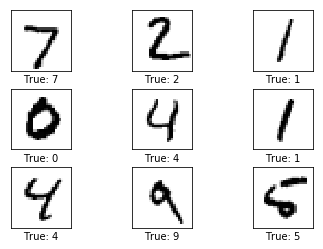

In [8]:
# getting a image set form test images 
images = data.test.images[0:9]

# getting classes for these images 
cls_true = data.test.cls[:9]

# using plot function 
plot_images(images, cls_true)

## Tensorflow graph 

In order to make a convolution we are going to follow our tf graph model to make a CNN

### Helper function to genrate new variables

In [9]:
# making a weights function 
def add_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [10]:
# making a bias function 
def add_biases(length):
    return tf.Variable(tf.constant(0.05, shape = [length]))

## Helper function to make a convolution layer 1 

In [11]:
def new_convolution_layer(previous_input, # previous layer 
                          num_input_channel, # number of channles in our images  
                          filter_size, # size of filter for this layer 
                          num_filters, # number of filters for this layer 
                          use_pooling=True): # use 2 * 2 pooling 
    # shape of filer weights 
    shape = [filter_size, filter_size, num_input_channel, num_filters]
    
    # create a new weights aka filter shape 
    weights = add_weights(shape=shape)
    
    # creating biases one of each filter 
    biases = add_biases(length=num_filters)
    
    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    
    layer = tf.nn.conv2d(input=previous_input,
                        filter = weights,
                        strides = [1, 1, 1, 1],
                        padding = 'SAME')
    
    # adding biases to our layer 
    layer += biases
    
    # adding pooling 
    if use_pooling:
        layer = tf.nn.max_pool(layer,ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    
    # performing reLU operation 
    
    layer = tf.nn.relu(layer)
    
    return layer, weights

### Helper function for making a flattened layer 

In this function we are going to flatten our layer i.e we are going to convert our layer into one dimensional. 

In [12]:
def make_flatten_layer(layer):
    # get the shape of input layer 
    layer_shape = layer.get_shape()
    
    num_features = layer_shape[1:4].num_elements()
    
    # time to reshape and flatten our layer 
    layer_flat = tf.reshape(layer, [-1, num_features])
    
    return layer_flat, num_features

### Helper function to create a fully connected layer



This function creates a new fully-connected layer in the computational graph for TensorFlow. Nothing is actually calculated here, we are just adding the mathematical formulas to the TensorFlow graph.

It is assumed that the input is a 2-dim tensor of shape [num_images, num_inputs]. The output is a 2-dim tensor of shape [num_images, num_outputs].

In [13]:
# function 
def new_fc_layer(previous_input,
                num_inputs,
                num_outputs,
                use_relu = True):
    
    # making a new weights 
    weights = add_weights(shape=[num_inputs, num_outputs])
    
    # generating new biases 
    biases = add_biases(length=num_outputs)
    
    # matrix multiplication 
    layer = tf.add(biases, tf.matmul(previous_input, weights))
    
    if use_relu:
        layer = tf.nn.relu(layer)
        
    return layer

### Placeholder Variables

In [14]:
# placeholder for images
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

In [15]:
# image size for input
x_image = tf.reshape(x, [-1, img_size, img_size, num_channel])

In [16]:
# label placeholder
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')

In [17]:
# true classes for our labels in one d
y_true_cls = tf.argmax(y_true, dimension=1)

Instructions for updating:
Use the `axis` argument instead


### Creating a convolution layer

In [18]:
# creting first convolution layer 
conv_layer1, conv_weights1 = new_convolution_layer(x_image, num_input_channel=num_channel, filter_size= filter_size1, 
                                                  num_filters=num_layers1)

In [19]:
conv_layer1

<tf.Tensor 'Relu:0' shape=(?, 14, 14, 16) dtype=float32>

In [20]:
conv_layer2, conv_weights2 = new_convolution_layer(conv_layer1, num_input_channel=num_layers1, filter_size=filter_size2, 
                                                   num_filters=num_layers2)

In [21]:
conv_layer2

<tf.Tensor 'Relu_1:0' shape=(?, 7, 7, 36) dtype=float32>

### Flatten Layer 

In [22]:
layer_flat, num_features = make_flatten_layer(conv_layer2)

In [23]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 1764) dtype=float32>

In [24]:
num_features

1764

### Fully connected layer

In [25]:
layer_fc1 = new_fc_layer(layer_flat, num_inputs=num_features,num_outputs=fc_layer, use_relu=True)

In [26]:
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

In [27]:
# fc layer 2 
layer_fc2 = new_fc_layer(layer_fc1, num_inputs=fc_layer, num_outputs=num_classes, use_relu=False)

In [28]:
layer_fc2

<tf.Tensor 'Add_3:0' shape=(?, 10) dtype=float32>

### Predicted Class

In [29]:
y_pred = tf.nn.softmax(layer_fc2)

In [30]:
# getting class number 
y_pred_cls = tf.argmax(y_pred, axis=1)

### Cost function to be optimized 

In [31]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc2,labels=y_true)

In [32]:
cost = tf.reduce_mean(cross_entropy)

### Optimization method 

In [33]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

## Performance Metrics 

We are in need of a performance matrix and techniques in order to make a efficient and optimized model along with the way to show progress to user

In [34]:
# to check if correct prediction or not 
correct_prediction = tf.equal(y_pred_cls,y_true_cls)

In [35]:
# to calculate accuracy of a model 
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Tensorflow Run 

Creating a session in order to run a TF garph.

In [36]:
# init session 
sess = tf.Session()

In [37]:
# initializing graph variables 
sess.run(tf.global_variables_initializer())

## Helper function to run optimization 

There are around 55000 images in our training set which can be really cumbersome and time consuming for gradients to be calculated, so we are only going to use a batch of images 

In [38]:
image_batch_size = 64

In [39]:
# making an optimization function 
total_iterations = 0
def optimize(num_iterations):
    global total_iterations
    
    #start time 
    start_time = time.time()    
    
    # iterating in num of iterations
    for i in range(total_iterations, total_iterations+ num_iterations):
        
        # getting a batches of images 
        x_batch, y_true_batch = data.train.next_batch(image_batch_size)
        
        # making a feed dict 
        feed_dict = {x:x_batch, y_true:y_true_batch}
        
        # running a optimizer 
        sess.run(optimizer, feed_dict=feed_dict)
        
        # displaying a progress to our users 
        if i % 100 == 0:
            # computing accuracy at that state 
            acc = sess.run(accuracy, feed_dict=feed_dict)
            
            # message to print
            msg = "Optimization iteration {:>6}, Train Accuracy {}%"
            
            # print it 
            print(msg.format(i+1, acc))
            
    # update number of iteration 
    total_iterations += num_iterations
    
    # end time 
    end_time = time.time()
    
    # print time ussage 
    print("Time ussage :" + str(timedelta(seconds = int(round(end_time - start_time)))))

In [40]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data.test.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.test.images[i:j, :]

        # Get the associated labels.
        labels = data.test.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = sess.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

## Performance before optimization 

Here is the time to show performance before any optimization

In [41]:
print_test_accuracy()

Accuracy on Test-Set: 8.5% (848 / 10000)


In [42]:
# performance after 1 optimization 
optimize(1)

Optimization iteration      1, Train Accuracy 0.171875%
Time ussage :0:00:00


In [43]:
print_test_accuracy()

Accuracy on Test-Set: 10.0% (997 / 10000)


## Performance after 100 optimization

After 100 optimizations model have significantly improved its accuracy

In [44]:
# since we already optimized it once to iterations = 99
optimize(num_iterations=99)

Time ussage :0:00:11


In [45]:
print_test_accuracy()

Accuracy on Test-Set: 71.7% (7174 / 10000)


## Performance accuracy after 1000 optimizations

In [46]:
optimize(900)

Optimization iteration    101, Train Accuracy 0.625%
Optimization iteration    201, Train Accuracy 0.875%
Optimization iteration    301, Train Accuracy 0.90625%
Optimization iteration    401, Train Accuracy 0.921875%
Optimization iteration    501, Train Accuracy 0.9375%
Optimization iteration    601, Train Accuracy 0.90625%
Optimization iteration    701, Train Accuracy 0.984375%
Optimization iteration    801, Train Accuracy 0.828125%
Optimization iteration    901, Train Accuracy 0.859375%
Time ussage :0:01:37


In [47]:
print_test_accuracy()

Accuracy on Test-Set: 92.7% (9272 / 10000)


## Performance accuracy after 10000 optimizations

In [48]:
optimize(9000)

Optimization iteration   1001, Train Accuracy 0.90625%
Optimization iteration   1101, Train Accuracy 0.90625%
Optimization iteration   1201, Train Accuracy 0.9375%
Optimization iteration   1301, Train Accuracy 0.890625%
Optimization iteration   1401, Train Accuracy 0.921875%
Optimization iteration   1501, Train Accuracy 0.953125%
Optimization iteration   1601, Train Accuracy 0.96875%
Optimization iteration   1701, Train Accuracy 0.890625%
Optimization iteration   1801, Train Accuracy 0.984375%
Optimization iteration   1901, Train Accuracy 0.90625%
Optimization iteration   2001, Train Accuracy 0.984375%
Optimization iteration   2101, Train Accuracy 0.96875%
Optimization iteration   2201, Train Accuracy 1.0%
Optimization iteration   2301, Train Accuracy 0.96875%
Optimization iteration   2401, Train Accuracy 0.984375%
Optimization iteration   2501, Train Accuracy 0.953125%
Optimization iteration   2601, Train Accuracy 0.953125%
Optimization iteration   2701, Train Accuracy 0.953125%
Optim

In [49]:
print_test_accuracy()

Accuracy on Test-Set: 98.6% (9855 / 10000)
